In [1]:
using DataFrames

In [2]:
cityPairs = readtable("sol64920.txt", separator=',', header=false)
cities = readtable("problem.csv", separator=',', header=false)
rename!(cities, Dict(:x1 => :city_id, :x2 => :xcoord, :x3 => :ycoord))
#cityPairs = cityPairs[:, [:x1, :x3]]
#rename!(cityPairs, Dict(:x1 => :origin, :x3 => :dest))
rename!(cityPairs, Dict(:x1 => :origin, :x2 => :agency, :x3 => :dest))


  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
in #readtable#84 at /home/geraq/.julia/v0.6/DataFrames/src/dataframe/io.jl
  likely near In[2]:1
in #readtable#84 at /home/geraq/.julia/v0.6/DataFrames/src/dataframe/io.jl
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
  likely near In[2]:1
in builddf at /home/geraq/.julia/v0.6/DataFrames/src/dataframe/io.jl


,origin,agency,dest
1,0,B,2743
2,2743,C,2465
3,2465,B,653
4,653,C,1463
5,1463,B,1228
6,1228,C,3662
7,3662,B,738
8,738,C,316
9,316,B,3680
10,3680,B,1349


In [3]:
distToPrice(distance::Float64) = distance * 0.01
euclideanDist(x::Vector{Float64}, y::Vector{Float64}) = sqrt(sum((x - y).^2))

function getFitness(pop::Matrix{Int}, distances::Vector{Float64}, prices::Vector{Float64})::Vector{Float64}  
  costs = getCosts(pop, distances, prices)  
  #return 1./ (abs(vec(sum(costs, 2)) - sum(prices)) + CORRECTION)
  #return 1./(abs(log(vec(sum(costs, 2))) - log(sum(prices))) + CORRECTION)
  #return 1./(log(vec(sum(costs, 2))) + CORRECTION)
  #return 1./(log(sqrt(vec(sum(costs, 2)))) + CORRECTION)
  #fitness = sum(prices) - vec(sum(costs, 2))
  fitness = sum(prices) - vec(sum(costs, 2))
  fitness[fitness .< 0] = 0
  #return fitness.^2
  return fitness  
end

function getCosts(pop::Matrix{Int}, distances::Vector{Float64}, prices::Vector{Float64})::Matrix{Float64}
  function fA(i::Int, trip::Int)
    timesInARow += 1
    if (timesInARow == 3)
      costs[i, trip] *= 0.65
      timesInARow = 0
    end
  end

  function fB(i::Int, trip::Int)
    timesInARow = 0
    if (distances[trip] > 200)
      costs[i, trip] *= 0.85
    end
  end

  function fC(i::Int, trip::Int)
    timesInARow = 0
    if (trip > 1 && pop[i, trip - 1] == 2)
      costs[i, trip] *= 0.80
    end
  end

  function fD(i::Int, trip::Int)
    timesInARow = 0
    accDist += distances[trip]
    nDiscounts = floor(Int, accDist / 1e4)
    accDist -= nDiscounts * 1e4
    costs[i, trip] -= nDiscounts * 15    
  end

  
  (M, nCities) = size(pop)    
  costs = repmat(prices', M, 1)  
  funcs = [fA, fB, fC, fD]
  timesInARow = 0
  accDist = 0
  for i in 1:M
    timesInARow = 0
    accDist = 0
    for trip in 1:nCities
      funcs[pop[i,trip]](i, trip)
    end
  end
  
  return costs
end

getCosts (generic function with 1 method)

In [4]:
nCities = size(cities, 1)

41011

In [5]:
distances = map(1:nCities) do i
      (originId, destId) = (cityPairs[i, :origin], cityPairs[i, :dest])      
      originCoordsDF = cities[cities[:city_id] .== originId, [:xcoord, :ycoord]]
      destCoordsDF = cities[cities[:city_id] .== destId, [:xcoord, :ycoord]]
      originCoords = vec(convert(Matrix{Float64}, originCoordsDF))
      destCoords = vec(convert(Matrix{Float64}, destCoordsDF))
      euclideanDist(originCoords, destCoords)
    end 
prices = map(distToPrice, distances)    

41011-element Array{Float64,1}:
 3.39918 
 2.85692 
 2.37371 
 2.88269 
 3.0913  
 1.55276 
 4.87976 
 4.15612 
 3.82974 
 2.12752 
 1.81184 
 4.15927 
 3.53227 
 ⋮       
 6.80294 
 2.89107 
 2.76274 
 1.77529 
 1.97519 
 2.86203 
 3.08638 
 0.469432
 3.15829 
 2.7216  
 2.40174 
 4.69473 

In [6]:
sum(prices)

77543.72213697474

In [123]:
fede = zeros(Int, 1, nCities)
fede[distances .<= 200] = 4
indicesB = find(distances .> 200)
#indicesC = filter(x -> x < nCities, indicesB + 1)
fede[indicesB] = 2
#fede[indicesC] = 3
for i in 1:length(fede)-1
    if fede[i] == 2
        fede[i+1] = 3
    end
end
# find Cs and replace by As
indices3D = find(fede[1:end-2] .== 4 .& 
    fede[2:end-1] .== 4 .& 
    fede[3:end] .== 4)


15611-element Array{Int64,1}:
    46
   141
   166
   175
   176
   177
   178
   179
   180
   181
   182
   183
   184
     ⋮
 40598
 40687
 40727
 40805
 40821
 40836
 40837
 40838
 40839
 40840
 40866
 40879

In [124]:
sum(getCosts(fede, distances, prices))

64815.30780530193

In [ ]:
indices3B = find(fede[1:end-2] .== 2 .& 
    fede[2:end-1] .== 2 .& 
    fede[3:end] .== 2)

In [8]:
fedeNew = copy(fede)

1×41011 Array{Int64,2}:
 2  3  3  3  3  3  2  3  3  3  3  2  3  …  2  3  3  3  4  2  3  3  2  3  3  2

In [9]:
function groupConsecutiveVals(list)
    lists = [[list[1]]]
    for i in list[2:end]
        if lists[end][end] + 1 == i
            push!(lists[end], i)
        else
            push!(lists, [i])
        end
    end
    return lists
end

In [ ]:
lists = groupConsecutiveVals(indicesD)

In [194]:
function isGoodToReplace(Dgroup)
    ddiscount = 45
    adiscount = prices[Dgroup[3]] * 0.35
    #println("$(ddiscount), $(adiscount), $(adiscount > ddiscount)")
    return adiscount > ddiscount
end

isGoodToReplace (generic function with 1 method)

In [11]:
function assignA(Dgroup, fede)
    N = length(Dgroup) + 2
    if (N == 3)
        if isGoodToReplace(Dgroup[1]:Dgroup[1]+2)
            fede[Dgroup[1]:Dgroup[1]+2] = 1
        end
    else
        if N < 6        
            x = Dgroup + 2
            indMaxDist = indmax(distances[x])
            best = x[indMaxDist]
            if isGoodToReplace(best-2:best)
                fede[best-2:best] = 1 
            end
        else N >= 6
            if isGoodToReplace(Dgroup[1:3])
                fede[Dgroup[1:3]] = 1
            end
            assignA(Dgroup[4:end], fede)        
        end
    end
end

assignA (generic function with 1 method)

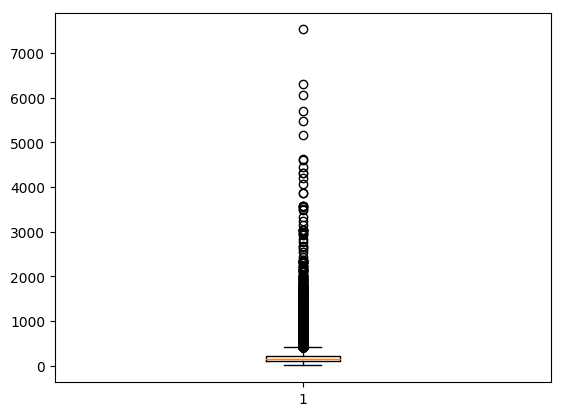

Dict{Any,Any} with 6 entries:
  "means"    => Any[]
  "whiskers" => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36fba00d10>…
  "fliers"   => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36fb864d90>]
  "boxes"    => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36fba00b10>]
  "caps"     => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36fba13a90>…
  "medians"  => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36fb864750>]

In [12]:
using PyPlot
plt[:boxplot](distances)

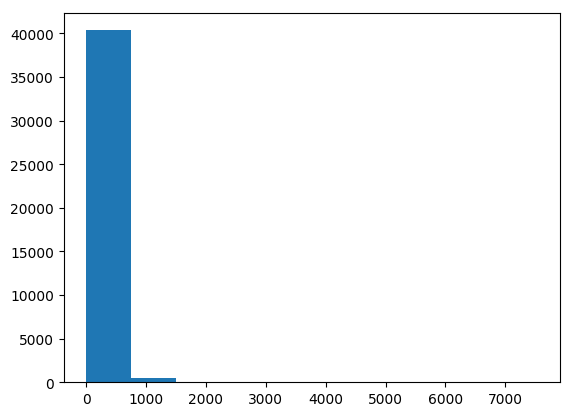

([40349.0, 527.0, 87.0, 20.0, 13.0, 7.0, 3.0, 2.0, 2.0, 1.0], [0.590339, 753.623, 1506.66, 2259.69, 3012.72, 3765.75, 4518.79, 5271.82, 6024.85, 6777.88, 7530.92], Any[PyObject <matplotlib.patches.Rectangle object at 0x7f36fb8c8910>, PyObject <matplotlib.patches.Rectangle object at 0x7f36fb8c8f90>, PyObject <matplotlib.patches.Rectangle object at 0x7f36fb8d2650>, PyObject <matplotlib.patches.Rectangle object at 0x7f36fb8d2cd0>, PyObject <matplotlib.patches.Rectangle object at 0x7f36fb7e2390>, PyObject <matplotlib.patches.Rectangle object at 0x7f36fb7e2a10>, PyObject <matplotlib.patches.Rectangle object at 0x7f36fb7e2f10>, PyObject <matplotlib.patches.Rectangle object at 0x7f36fb7ef750>, PyObject <matplotlib.patches.Rectangle object at 0x7f36fb7efdd0>, PyObject <matplotlib.patches.Rectangle object at 0x7f36fb7fc490>])

In [13]:
plt[:hist](distances)

In [14]:
sum(distances .>= 200)

12682

In [15]:
mean(distances) * 0.35

66.17810525942103

In [16]:
allD = ones(Int, 1, nCities) * 4
costsD = getCosts(allD, distances, prices)
sum(costsD)

65918.72213697474

In [17]:
sum(getCosts(fede, distances, prices))

68881.40388142288

In [195]:
for xs in lists    
    #println(xs)
    assignA(xs, fedeNew)
end

In [35]:
fede

1×41011 Array{Int64,2}:
 2  3  2  3  2  3  2  3  2  3  4  2  3  …  2  3  2  3  4  2  3  4  2  3  2  3

In [36]:
costFede = getCosts(fede, distances, prices)
sum(costFede)

64815.30780530193

In [41]:
sum(costFede) - 25.82391243978782

64789.48389286214

In [25]:
sum(prices)

77543.72213697474

In [26]:
mapping = Dict("A" => 1, "B" => 2, "C" => 3, "D" => 4)
originalSolution = convert(Matrix{Int}, [mapping[c] for c in cityPairs[:agency]]')

1×41011 Array{Int64,2}:
 2  3  2  3  2  3  2  3  2  2  3  2  3  …  2  3  2  3  4  2  3  3  2  3  2  3

In [37]:
costsOriginal = getCosts(originalSolution, distances, prices)
sum(costsOriginal)

64920.25391243979

In [ ]:
#64,894.43

In [40]:
sum(costsOriginal) - 64894.43

25.82391243978782

In [29]:
counts = map(x -> (x, sum(originalSolution .== x)), unique(originalSolution))

4-element Array{Tuple{Int64,Int64},1}:
 (2, 9923) 
 (3, 8926) 
 (4, 22144)
 (1, 18)   

In [30]:
fedecounts = map(x -> (x, sum(fede .== x)), unique(fede))

3-element Array{Tuple{Int64,Int64},1}:
 (2, 6188) 
 (3, 12680)
 (4, 22143)

In [32]:
length(indicesC)

12680

In [33]:
fedeNewcounts = map(x -> (x, sum(fedeNew .== x)), unique(fedeNew))

3-element Array{Tuple{Int64,Int64},1}:
 (2, 6188) 
 (3, 12680)
 (4, 22143)

In [58]:
newDF = copy(cityPairs[[:origin, :dest]])
vals = map(i -> string(collect("ABCD")[i]), fede)
newDF[:agency] = vec(vals)
#newDF[:, :agency]



41011-element Array{String,1}:
 "B"
 "C"
 "B"
 "C"
 "B"
 "C"
 "B"
 "C"
 "B"
 "C"
 "D"
 "B"
 "C"
 ⋮  
 "B"
 "C"
 "B"
 "C"
 "D"
 "B"
 "C"
 "D"
 "B"
 "C"
 "B"
 "C"

In [61]:
newDF = newDF[[:origin, :agency, :dest]]

,origin,agency,dest
1,0,B,2743
2,2743,C,2465
3,2465,B,653
4,653,C,1463
5,1463,B,1228
6,1228,C,3662
7,3662,B,738
8,738,C,316
9,316,B,3680
10,3680,C,1349


In [62]:
writetable("solfede.txt", newDF, header=false)

  likely near In[62]:1
  likely near In[62]:1
  likely near In[62]:1
  likely near In[62]:1
  likely near In[62]:1
  likely near In[62]:1
  likely near In[62]:1
  likely near In[62]:1
  likely near In[62]:1


In [63]:
fede2 = copy(fede)
for i in 2:length(nCities)
    if (fede2[i] == 4) && (fede2[i-1] == 4) && prices[i] > 150
        fede2[i-1] = 2
        fede2[i] = 3
    end
end

In [65]:
sum(getCosts(fede2, distances, prices))

64815.30780530193

In [72]:
sum((fede .== 4) & (prices[vec(fede.==4)] .> 150))

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] &(::BitArray{2}, ::BitArray{1}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:515
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/geraq/.julia/v0.6/IJulia/src/execute_request.jl:160
 [5] eventloop(::ZMQ.Socket) at /home/geraq/.julia/v0.6/IJulia/src/eventloop.jl:8
 [6] (::IJulia.##11#14)() at ./task.jl:335
while loading In[72], in expression starting on line 1


LoadError: [91mDimensionMismatch("dimensions must match")[39m

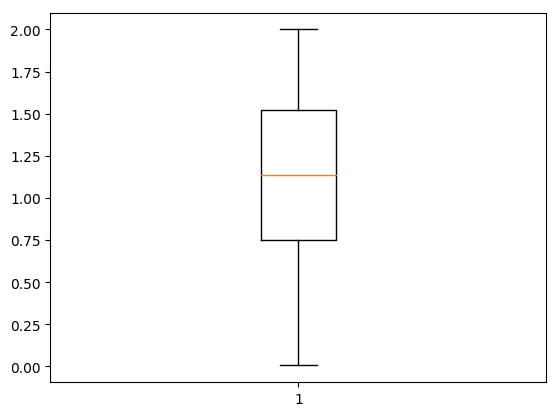

Dict{Any,Any} with 6 entries:
  "means"    => Any[]
  "whiskers" => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36f1311250>…
  "fliers"   => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36f132b2d0>]
  "boxes"    => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36f1311050>]
  "caps"     => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36f1311f90>…
  "medians"  => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36f131ec50>]

In [91]:
plt[:boxplot](prices[(distances .< 200)])

In [93]:
maximum(distances)

7530.917158620189

In [95]:
sum(getCosts(allD, distances, prices))

65918.72213697474

In [100]:
sum(getCosts(fede, distances, prices))

64815.30780530193

In [99]:
fede

1×41011 Array{Int64,2}:
 2  3  2  3  2  3  2  3  2  3  4  2  3  …  2  3  2  3  4  2  3  4  2  3  2  3

In [103]:
indicesBC = find((fede[1:end-1] .== 2) .& (fede[2:end] .== 3))

8581-element Array{Int64,1}:
     1
     3
     5
     7
     9
    12
    14
    16
    18
    20
    22
    24
    27
     ⋮
 40985
 40987
 40989
 40991
 40993
 40995
 40997
 41000
 41002
 41005
 41008
 41010

In [172]:
fede2 = copy(fede)
for i in 1:nCities-1
    if ((fede2[i] == 2) && (fede2[i+1] == 3) && ((0.15 * prices[i]) + (0.2 * prices[i+1]) < (distances[i] + distances[i+1])*0.0015))
        fede2[i] = 4
        fede2[i+1] = 4
    end
end

In [178]:
sum((distances[vec(fede .== 4)])) % 10000

5863.3015782604925

In [173]:
sum(getCosts(fede2, distances, prices))

64815.30780530193

In [147]:
sum(getCosts(fede, distances, prices))

64815.30780530193

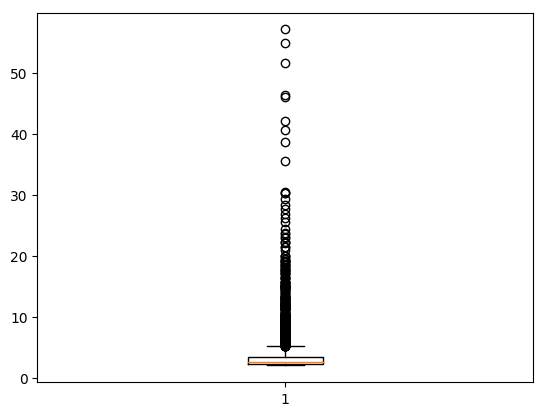

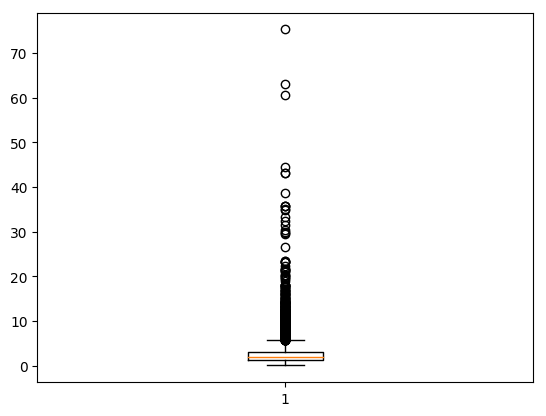

Dict{Any,Any} with 6 entries:
  "means"    => Any[]
  "whiskers" => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36f0ea8d10>…
  "fliers"   => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36f0e10810>]
  "boxes"    => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36f0eb4b50>]
  "caps"     => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36f10121d0>…
  "medians"  => Any[PyObject <matplotlib.lines.Line2D object at 0x7f36f0e101d0>]

In [138]:
plt[:boxplot](prices[vec(fede .== 2)])
figure()
plt[:boxplot](prices[vec(fede .== 3)])

In [159]:
unique((prices - vec(getCosts(fede2, distances, prices)))[vec(fede .!= fede2)])
#getCosts(fede2, distances, prices)

2-element Array{Float64,1}:
  0.0
 15.0

In [164]:
sum(getCosts(allD, distances, prices))

65918.72213697474

In [155]:
size(fede2)

(1, 41011)

In [188]:
sum(distances) % 10000

4372.21369747445

In [170]:
allBC = [repmat([2,3]', 1, floor(Int,nCities/2)) 2]

1×41011 Array{Int64,2}:
 2  3  2  3  2  3  2  3  2  3  2  3  2  …  3  2  3  2  3  2  3  2  3  2  3  2

In [171]:
sum(getCosts(allBC, distances, prices))

66380.53489626871

In [180]:
function groupEqualVals(list)
    lists = [[list[1]]]
    for i in list[2:end]
        if lists[end][end] == i
            push!(lists[end], i)
        else
            push!(lists, [i])
        end
    end
    return lists
end

groupEqualVals (generic function with 1 method)

In [183]:
fede[1]

2

In [186]:
filter(xs -> length(xs) == 3, groupEqualVals(fede))

545-element Array{Array{Int64,1},1}:
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 ⋮        
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]
 [4, 4, 4]

In [189]:
allA = ones(Int, 1, nCities) * 1
costsA = getCosts(allA, distances, prices)
sum(costsA)

68513.86838510979

In [190]:
allB = ones(Int, 1, nCities) * 2
costsB = getCosts(allB, distances, prices)
sum(costsB)

70704.88616980021

In [192]:
mean(prices)

1.8908030074120294